# **📘LangGraph Persistence**

### 🔹 1. **What is Persistence in LangGraph?**

* Refers to the **ability to save and restore the state of a workflow** over time.
* Solves LangGraph's default behavior where state is erased after execution.
* Enables **workflow state** (both intermediate and final) to be stored in external storage (e.g., databases).

---

### 🔹 2. **Core Concepts**

#### 📊 Graphs and Tasks

* High-level goals are broken down into **tasks**.
* Represented as a **graph**: nodes = tasks, edges = execution order.

#### 💾 State

* Central shared **dictionary-like structure** used by all nodes.
* Nodes can **read and write** to the state.
* Includes data like inputs, results, and context (e.g., messages in a chatbot).

---

### 🔹 3. **Why Persistence is Needed**

* **Short-Term Memory (Chatbots)**:

  * Enables conversation history to persist and resume.

* **Fault Tolerance**:

  * If a crash occurs, execution can **resume from the last checkpoint**, not from the start.

* **Human-in-the-Loop (HITL)**:

  * Supports pausing workflows and resuming later without losing progress.

* **Time Travel (Debugging & Replay)**:

  * Allows replaying past execution from any checkpoint.
  * Useful for debugging or re-running modified state paths.

---

### 🔹 4. **How Persistence Works**

#### 🧠 A. Checkpointers

* Divide execution into **checkpoints** at each **superstep** (can include parallel tasks).
* Save state (intermediate + final) to storage.
* Types:

  * `InMemorySaver`: For demos (RAM only).
  * **Database-backed** (e.g., PostgreSQL, Redis): For production.
* Usage:

  * Instantiate checkpointer and pass into `graph.compile(checkpointer=...)`.

#### 🧵 B. Thread IDs

* Assign unique `thread_id` for each workflow execution.
* Allow **tracking and retrieving state history** per execution.
* Used to distinguish between different conversations/users in chatbots.
* Functions:

  * `workflow.get_state(config)`
  * `workflow.get_state_history(config)`

---

### 🔹 5. **Practical Example**

#### 💡 Joke Workflow

* **State**: `{ joke_topic, joke_text, joke_explanation }`
* **Nodes**:

  * `generate_joke`
  * `generate_explanation`
* **Execution**:

  * Run with topic = `"pizza"`, `thread_id = "1"`
  * Another run with topic = `"pasta"`, `thread_id = "2"`
* **Result**:

  * Both have isolated, retrievable state histories.

---

### 🔹 6. **Key Features Enabled by Persistence**

#### 💬 Chatbots with Memory

* Resume conversations using stored state per thread.

#### 🔁 Fault Tolerance

* Resume from crash point using last checkpoint.

#### 👤 HITL Support

* Temporarily pause and resume workflows after human input.

#### 🕰️ Time Travel

* Replay or debug workflows from any saved checkpoint.
* Use `checkpoint_id` to:

  * Retrieve specific state.
  * Update state.
  * Resume or re-run workflow.

---

### 🔹 7. **Key Methods and Usage**

| Purpose                    | Method / Tool                                                         |
| -------------------------- | --------------------------------------------------------------------- |
| Define checkpointer        | `InMemorySaver()` or DB-backed checkpointers                          |
| Compile with persistence   | `graph.compile(checkpointer=...)`                                     |
| Run with thread ID         | `workflow.invoke(..., config={"configurable": {"thread_id": "..."}})` |
| Get final state            | `workflow.get_state(config)`                                          |
| Get state history          | `workflow.get_state_history(config)`                                  |
| Resume from checkpoint     | `invoke(None, config={..., "checkpoint_id": "..."})`                  |
| Update state before replay | `workflow.update_state(...)`                                          |

In [64]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict
from langchain_groq import ChatGroq
from langgraph.checkpoint.memory import InMemorySaver

from dotenv import load_dotenv
load_dotenv()

True

In [65]:
# Initialize the ChatGroq LLM 
llm = ChatGroq(model="llama-3.1-8b-instant")

In [66]:
class JokeState(TypedDict):

    topic: str
    joke: str
    explanation: str

In [67]:
def generate_joke(state: JokeState):
    prompt = f'generate a joke on the topic {state["topic"]}'
    response = llm.invoke(prompt).content
    return {'joke': response}

def generate_explanation(state: JokeState):
    prompt = f'write an explanation for the joke - {state["joke"]}'
    response = llm.invoke(prompt).content
    return {'explanation': response}

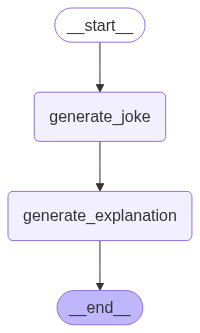

In [68]:
graph = StateGraph(JokeState)

graph.add_node('generate_joke', generate_joke)
graph.add_node('generate_explanation', generate_explanation)

graph.add_edge(START, 'generate_joke')
graph.add_edge('generate_joke', 'generate_explanation')
graph.add_edge('generate_explanation', END)

checkpointer = InMemorySaver()

workflow = graph.compile(checkpointer=checkpointer)
workflow

### **📥Config1**

In [69]:
config1 = {"configurable": {"thread_id": "1"}}
workflow.invoke({'topic':'frog'}, config=config1)

{'topic': 'frog',
 'joke': 'Why did the frog go to the doctor?\n\nBecause it had a "toad-ally" bad cough.',
 'explanation': 'The joke is a play on words, using a pun to create humor. The phrase "toad-ally" is a clever pun on the word "totally," which is a common adverb meaning completely or entirely. However, in this joke, it\'s replaced with "toad-ally," referencing the fact that a toad is a type of amphibian, closely related to frogs.\n\nThe joke relies on this wordplay to create a pun, which is a form of humor that exploits multiple meanings of a word or phrase. In this case, the pun is used to create a clever and unexpected connection between the idea of a frog\'s bad cough and the word "toad-ally," creating a lighthearted and amusing effect.\n\nThe joke also uses a bit of unexpected twist, as it sets up the expectation that the frog went to the doctor for a serious reason, but instead subverts it with a pun, making it a clever and amusing way to end the joke.'}

In [70]:
workflow.get_state(config1)

StateSnapshot(values={'topic': 'frog', 'joke': 'Why did the frog go to the doctor?\n\nBecause it had a "toad-ally" bad cough.', 'explanation': 'The joke is a play on words, using a pun to create humor. The phrase "toad-ally" is a clever pun on the word "totally," which is a common adverb meaning completely or entirely. However, in this joke, it\'s replaced with "toad-ally," referencing the fact that a toad is a type of amphibian, closely related to frogs.\n\nThe joke relies on this wordplay to create a pun, which is a form of humor that exploits multiple meanings of a word or phrase. In this case, the pun is used to create a clever and unexpected connection between the idea of a frog\'s bad cough and the word "toad-ally," creating a lighthearted and amusing effect.\n\nThe joke also uses a bit of unexpected twist, as it sets up the expectation that the frog went to the doctor for a serious reason, but instead subverts it with a pun, making it a clever and amusing way to end the joke.'},

In [71]:
list(workflow.get_state_history(config1))

[StateSnapshot(values={'topic': 'frog', 'joke': 'Why did the frog go to the doctor?\n\nBecause it had a "toad-ally" bad cough.', 'explanation': 'The joke is a play on words, using a pun to create humor. The phrase "toad-ally" is a clever pun on the word "totally," which is a common adverb meaning completely or entirely. However, in this joke, it\'s replaced with "toad-ally," referencing the fact that a toad is a type of amphibian, closely related to frogs.\n\nThe joke relies on this wordplay to create a pun, which is a form of humor that exploits multiple meanings of a word or phrase. In this case, the pun is used to create a clever and unexpected connection between the idea of a frog\'s bad cough and the word "toad-ally," creating a lighthearted and amusing effect.\n\nThe joke also uses a bit of unexpected twist, as it sets up the expectation that the frog went to the doctor for a serious reason, but instead subverts it with a pun, making it a clever and amusing way to end the joke.'}

### **📥Config2**

In [72]:
config2 = {"configurable": {"thread_id": "2"}}
workflow.invoke({'topic':'monkey'}, config=config2)

{'topic': 'monkey',
 'joke': 'Why did the monkey get kicked out of the library? \n\nBecause he was caught monkeying around.',
 'explanation': 'The joke is a play on words, which is a common technique used in puns. \n\nThe phrase "monkeying around" has two meanings here: \n\n1. In a literal sense, a monkey is a primate known for its agility and mischievous behavior, so it\'s not uncommon for a monkey to be active and playful, which might be interpreted as "monkeying around."\n\n2. The phrase "monkeying around" is also an idiomatic expression that means to be misbehaving or causing trouble, often in a way that\'s playful but also annoying.\n\nThe joke relies on this double meaning to create humor. The punchline "because he was caught monkeying around" is a clever play on words, as it uses the literal meaning of "monkeying around" to describe the monkey\'s behavior, while also referencing the idiomatic expression to explain why the monkey got kicked out of the library. The humor comes fro

In [73]:
workflow.get_state(config2)

StateSnapshot(values={'topic': 'monkey', 'joke': 'Why did the monkey get kicked out of the library? \n\nBecause he was caught monkeying around.', 'explanation': 'The joke is a play on words, which is a common technique used in puns. \n\nThe phrase "monkeying around" has two meanings here: \n\n1. In a literal sense, a monkey is a primate known for its agility and mischievous behavior, so it\'s not uncommon for a monkey to be active and playful, which might be interpreted as "monkeying around."\n\n2. The phrase "monkeying around" is also an idiomatic expression that means to be misbehaving or causing trouble, often in a way that\'s playful but also annoying.\n\nThe joke relies on this double meaning to create humor. The punchline "because he was caught monkeying around" is a clever play on words, as it uses the literal meaning of "monkeying around" to describe the monkey\'s behavior, while also referencing the idiomatic expression to explain why the monkey got kicked out of the library. 

In [74]:
list(workflow.get_state_history(config2))

[StateSnapshot(values={'topic': 'monkey', 'joke': 'Why did the monkey get kicked out of the library? \n\nBecause he was caught monkeying around.', 'explanation': 'The joke is a play on words, which is a common technique used in puns. \n\nThe phrase "monkeying around" has two meanings here: \n\n1. In a literal sense, a monkey is a primate known for its agility and mischievous behavior, so it\'s not uncommon for a monkey to be active and playful, which might be interpreted as "monkeying around."\n\n2. The phrase "monkeying around" is also an idiomatic expression that means to be misbehaving or causing trouble, often in a way that\'s playful but also annoying.\n\nThe joke relies on this double meaning to create humor. The punchline "because he was caught monkeying around" is a clever play on words, as it uses the literal meaning of "monkeying around" to describe the monkey\'s behavior, while also referencing the idiomatic expression to explain why the monkey got kicked out of the library.

## **💥1. Fault Tolerance**

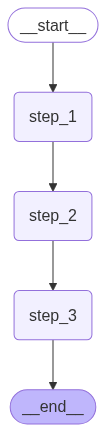

In [75]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import InMemorySaver
from typing import TypedDict
import time

# 1. Define the state
class CrashState(TypedDict, total=False):  # Use total=False to make keys optional
    input: str
    step1: str
    step2: str
    step3: str

# 2. Define Steps
def step_1(state: CrashState): 
    print("✅ Step 1 is Executed")
    return {"step1": "done", "input": state["input"]}

def step_2(state: CrashState):
    print("⌛ Step 2 is hanging... now manually interrupt from the notebook toolbar (STOP Button)")
    time.sleep(30)  # Simulate long-running process
    return {"step2": "done"}

def step_3(state: CrashState): 
    print("✅ Step 3 is Executed")
    return {"step3": "done"}

# 3. Build the graph
builder = StateGraph(CrashState)
builder.add_node("step_1", step_1)
builder.add_node("step_2", step_2)
builder.add_node("step_3", step_3)

builder.add_edge(START, "step_1")
builder.add_edge("step_1", "step_2")
builder.add_edge("step_2", "step_3")
builder.add_edge("step_3", END)

# 5. Use an in-memory checkpoint saver
checkpointer = InMemorySaver()
graph = builder.compile(checkpointer=checkpointer)

graph

### **❌ Kernel manually interrupted**

In [76]:
# Run the graph
try:
    print("▶️ Running graph: Please manually interrupt during Step 2...")
    graph.invoke({"input": "start"}, config={"configurable": {"thread_id": "thread-1"}})
except KeyboardInterrupt:
    print("❌ Kernel manually interrupted (crash simulated).")

▶️ Running graph: Please manually interrupt during Step 2...
✅ Step 1 is Executed
⌛ Step 2 is hanging... now manually interrupt from the notebook toolbar (STOP Button)
❌ Kernel manually interrupted (crash simulated).


In [77]:
graph.get_state({"configurable": {"thread_id": "thread-1"}})

StateSnapshot(values={'input': 'start', 'step1': 'done'}, next=('step_2',), config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f072d72-b924-6017-8001-4a02d228c6bb'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}, 'thread_id': 'thread-1'}, created_at='2025-08-06T15:08:12.302529+00:00', parent_config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f072d72-b921-62c6-8000-d5eef96e0bd5'}}, tasks=(PregelTask(id='e5fb1564-fd7f-200f-42f2-63c323b651d6', name='step_2', path=('__pregel_pull', 'step_2'), error=None, interrupts=(), state=None, result=None),), interrupts=())

In [78]:
list(graph.get_state_history({"configurable": {"thread_id": "thread-1"}}))

[StateSnapshot(values={'input': 'start', 'step1': 'done'}, next=('step_2',), config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f072d72-b924-6017-8001-4a02d228c6bb'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}, 'thread_id': 'thread-1'}, created_at='2025-08-06T15:08:12.302529+00:00', parent_config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f072d72-b921-62c6-8000-d5eef96e0bd5'}}, tasks=(PregelTask(id='e5fb1564-fd7f-200f-42f2-63c323b651d6', name='step_2', path=('__pregel_pull', 'step_2'), error=None, interrupts=(), state=None, result=None),), interrupts=()),
 StateSnapshot(values={'input': 'start'}, next=('step_1',), config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f072d72-b921-62c6-8000-d5eef96e0bd5'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}, 'thread_id': 'thread-1'}, created_at='2025-08-06T15:08:12.301361+00:00', parent_config={'configurable': 

### **✅Resuming from saved state**

In [79]:
# 6. Re-run to show fault-tolerant resume
final_state = graph.invoke(
    None,  # No new input needed since it's resuming from saved state
    config={"configurable": {"thread_id": "thread-1"}}
)
print("\n✅ Final State:", final_state)

⌛ Step 2 is hanging... now manually interrupt from the notebook toolbar (STOP Button)
✅ Step 3 is Executed

✅ Final State: {'input': 'start', 'step1': 'done', 'step2': 'done', 'step3': 'done'}


In [80]:
graph.get_state({"configurable": {"thread_id": "thread-1"}})

StateSnapshot(values={'input': 'start', 'step1': 'done', 'step2': 'done', 'step3': 'done'}, next=(), config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f072d75-55e6-67a1-8003-4a15386bf085'}}, metadata={'source': 'loop', 'step': 3, 'parents': {}, 'thread_id': 'thread-1'}, created_at='2025-08-06T15:09:22.427064+00:00', parent_config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f072d75-55e4-607d-8002-c812e89581c2'}}, tasks=(), interrupts=())

In [81]:
list(graph.get_state_history({"configurable": {"thread_id": "thread-1"}}))

[StateSnapshot(values={'input': 'start', 'step1': 'done', 'step2': 'done', 'step3': 'done'}, next=(), config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f072d75-55e6-67a1-8003-4a15386bf085'}}, metadata={'source': 'loop', 'step': 3, 'parents': {}, 'thread_id': 'thread-1'}, created_at='2025-08-06T15:09:22.427064+00:00', parent_config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f072d75-55e4-607d-8002-c812e89581c2'}}, tasks=(), interrupts=()),
 StateSnapshot(values={'input': 'start', 'step1': 'done', 'step2': 'done'}, next=('step_3',), config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f072d75-55e4-607d-8002-c812e89581c2'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}, 'thread_id': 'thread-1'}, created_at='2025-08-06T15:09:22.426023+00:00', parent_config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f072d72-b924-6017-8001-4a02d22

## **➿2. HITL(Human in the Loop)**

### 🧠 **Human-in-the-Loop (HITL) in LangGraph Workflow**

📌 **Overall Workflow**:

```
🟨 Topic 
   ↓
🧾 LinkedIn Post ───────▶ (active)
                             ↓
                          🧑‍🦱 HITL
                             ↓
                          🛑 Interrupt 
                             ↓
                          ✅ Resume
                             ↓
                          🔵 API

```

### 🔁 **Concept & Flow Explanation**

* 🟨 **"Topic"**:

  * Start of the workflow.
  * A topic is generated or selected to begin the automated process.

* 🧾 **"LinkedIn Post"**:

  * An automated step generates a LinkedIn post from the topic.
  * The process is fully machine-driven up to this point.

* 👤 **Human-in-the-Loop (HITL)**:

  * The workflow **pauses here**, waiting for **human input, approval, or editing**.
  * The system deliberately **interrupts** here — this is **not a crash**, but a controlled halt.

* 🛑 **Interrupt (Red)**:

  * Highlights the intentional pause after the post is created.
  * At this stage, memory cannot remain active (e.g., human may respond after hours/days).

* 💾 **Persistence (LangGraph’s Superpower)**:

  * LangGraph **saves the state** of the graph at each step (checkpoint).
  * When the human provides input later, LangGraph can **resume from exactly where it left off**.

* 🔁 **Resume (Green)**:

  * Once the human gives input, LangGraph **resumes execution**.
  * Continues with calling the final 🔵 **API** step using the updated content.

---

### ⚖️ **Comparison with Fault Tolerance**

| Feature              | Human-in-the-Loop (HITL)     | Fault Tolerance                     |
| -------------------- | ---------------------------- | ----------------------------------- |
| 🛑 **Interruption**  | Deliberate pause for human   | Unplanned (e.g., crash or failure)  |
| 🕒 **Resume Timing** | Can resume after long delay  | Resumes ASAP once issue is resolved |
| 💾 **Persistence**   | Used to wait for human input | Used to recover from system failure |



## **⏳Time Travel**

In [84]:
workflow.get_state({
    "configurable": {"thread_id": "1", "checkpoint_id": "1f072d72-ab84-69a8-8000-3d25b648b3f6"}}
    )

StateSnapshot(values={'topic': 'frog'}, next=('generate_joke',), config={'configurable': {'thread_id': '1', 'checkpoint_id': '1f072d72-ab84-69a8-8000-3d25b648b3f6'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}, 'thread_id': '1'}, created_at='2025-08-06T15:08:10.874083+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f072d72-ab80-6c4b-bfff-1254ff4339de'}}, tasks=(PregelTask(id='223dfa4d-8b04-5378-4cd3-1681c8bd54df', name='generate_joke', path=('__pregel_pull', 'generate_joke'), error=None, interrupts=(), state=None, result={'joke': 'Why did the frog go to the doctor?\n\nBecause it had a "toad-ally" bad cough.'}),), interrupts=())

In [85]:
workflow.invoke(
    None, 
    {"configurable": {"thread_id": "1", "checkpoint_id": "1f072d72-ab84-69a8-8000-3d25b648b3f6"}}
    )

{'topic': 'frog',
 'joke': 'Why did the frog go to the doctor? \n\nBecause it had a "ribbiting" cough.',
 'explanation': 'The joke is a play on words. "Ribbiting" has a double meaning here:\n\n1. In its literal sense, "ribbit" is the sound a frog makes, similar to a laugh or a chuckle.\n2. In an idiomatic sense, "ribbiting" sounds like "rib-tickling" or "gut-wrenching," which means extremely funny or laugh-out-loud hilarious.\n\nSo, the punchline "it had a ribbiting cough" is a clever pun that combines the frog\'s distinctive sound with the idea of something being laugh-out-loud funny, implying that the frog\'s cough is so severe or unusual that it\'s almost comical. The joke relies on the wordplay between the literal and idiomatic meanings of "ribbiting" to create a humorous effect.'}

In [86]:
list(workflow.get_state_history(config1))

[StateSnapshot(values={'topic': 'frog', 'joke': 'Why did the frog go to the doctor? \n\nBecause it had a "ribbiting" cough.', 'explanation': 'The joke is a play on words. "Ribbiting" has a double meaning here:\n\n1. In its literal sense, "ribbit" is the sound a frog makes, similar to a laugh or a chuckle.\n2. In an idiomatic sense, "ribbiting" sounds like "rib-tickling" or "gut-wrenching," which means extremely funny or laugh-out-loud hilarious.\n\nSo, the punchline "it had a ribbiting cough" is a clever pun that combines the frog\'s distinctive sound with the idea of something being laugh-out-loud funny, implying that the frog\'s cough is so severe or unusual that it\'s almost comical. The joke relies on the wordplay between the literal and idiomatic meanings of "ribbiting" to create a humorous effect.'}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f072d78-f2c6-650e-8002-80a8628e7b10'}}, metadata={'source': 'loop', 'step': 2, 'parents': 

## **⤴️Updating State**

In [87]:
workflow.update_state(
    {"configurable": {"thread_id": "1", "checkpoint_id": "1f072d72-ab84-69a8-8000-3d25b648b3f6", "checkpoint_ns": ""}},
    {'topic':'samosa'}
    )

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f072d7b-b22c-624b-8001-d34dc509b2a5'}}

In [88]:
list(workflow.get_state_history(config1))

[StateSnapshot(values={'topic': 'samosa'}, next=('generate_joke',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f072d7b-b22c-624b-8001-d34dc509b2a5'}}, metadata={'source': 'update', 'step': 1, 'parents': {}, 'thread_id': '1'}, created_at='2025-08-06T15:12:13.163768+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f072d72-ab84-69a8-8000-3d25b648b3f6'}}, tasks=(PregelTask(id='e6d3d10d-a207-2fcb-268e-b8c75f069edf', name='generate_joke', path=('__pregel_pull', 'generate_joke'), error=None, interrupts=(), state=None, result=None),), interrupts=()),
 StateSnapshot(values={'topic': 'frog', 'joke': 'Why did the frog go to the doctor? \n\nBecause it had a "ribbiting" cough.', 'explanation': 'The joke is a play on words. "Ribbiting" has a double meaning here:\n\n1. In its literal sense, "ribbit" is the sound a frog makes, similar to a laugh or a chuckle.\n2. In an idiomatic sense, "ribbiting" sounds like "rib

In [89]:
workflow.invoke(None, {"configurable": {"thread_id": "1", "checkpoint_id": "1f072d7b-b22c-624b-8001-d34dc509b2a5"}})

{'topic': 'samosa',
 'joke': 'Why did the samosa go to therapy? \n\nBecause it was feeling crumby.',
 'explanation': 'The joke relies on wordplay, using the phrase "feeling crumby" in two different ways. \n\nIn the first instance, "feeling crumby" is an idiom that means feeling unwell, unhappy, or in a bad mood. This is a common expression used to describe someone\'s emotional state.\n\nIn the second instance, "crumby" also refers to something that is crumbling or falling apart, which is a characteristic of a samosa when it\'s not fresh or has been mishandled. Samosas are a type of fried or baked pastry dish that is typically crispy on the outside and soft on the inside, but when they become stale or old, they can become crumby.\n\nThe joke is funny because it takes the common phrase "feeling crumby" and applies it to a samosa, which is literally prone to becoming crumby. It\'s a clever play on words that creates a unexpected connection between the phrase and the subject of the joke.'}

In [90]:
list(workflow.get_state_history(config1))

[StateSnapshot(values={'topic': 'samosa', 'joke': 'Why did the samosa go to therapy? \n\nBecause it was feeling crumby.', 'explanation': 'The joke relies on wordplay, using the phrase "feeling crumby" in two different ways. \n\nIn the first instance, "feeling crumby" is an idiom that means feeling unwell, unhappy, or in a bad mood. This is a common expression used to describe someone\'s emotional state.\n\nIn the second instance, "crumby" also refers to something that is crumbling or falling apart, which is a characteristic of a samosa when it\'s not fresh or has been mishandled. Samosas are a type of fried or baked pastry dish that is typically crispy on the outside and soft on the inside, but when they become stale or old, they can become crumby.\n\nThe joke is funny because it takes the common phrase "feeling crumby" and applies it to a samosa, which is literally prone to becoming crumby. It\'s a clever play on words that creates a unexpected connection between the phrase and the su